## Dermatology pathology classifier

### Import dependencies

In [1]:
import os
import urllib
import shutil
import azureml

from azureml.core import Workspace, Run

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.train.dnn import TensorFlow

import numpy as np

### Download dermatology pathologies dataset from Azure Datasets

In [2]:
from azureml.core import Dataset

subscription_id = '660e5fe0-cf93-44e8-a691-2a56b0140d4b'
resource_group = 'dh6'
workspace_name = 'skin-disorder-classifier'

ws = Workspace(subscription_id, resource_group, workspace_name)

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

dataset = Dataset.get_by_name(ws, name='derm dataset')
dataset.download(data_folder, overwrite=False)

RuntimeError: File "/mnt/azmnt/code/Users/renx11/DermDiseaseDetect/data/test/melanoma/ISIC_0011510.jpg" already exists. Set overwrite=True to overwrite it.

### Create Experiment

In [3]:
from azureml.core import Experiment
experiment_name = 'derm-classifer'

exp = Experiment(workspace=ws, name=experiment_name)

### Create a compute target

In [4]:
cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target


### Read dataset as pixel values into a list

In [5]:
from matplotlib import image
from os import walk

class_names = {'melanoma':0, 'nevus':1, 'seborrheic_keratosis':2}

X = list()
y = list()
for filename in walk('data/train'):
    if filename[2]:
        for file in filename[2]:
            img_data = image.imread(filename[0]+"/"+file)
            X.append(img_data)
            y.append(class_names[filename[0][11:]])
            #print('> loaded %s %s' % (file, img_data.shape))
            

### Convert lists to numpy arrays

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

### Examine a random training image

In [7]:
import matplotlib.pyplot as plt

import random
rand = random.randint(0,len(X_train)-1)
plt.imshow(X_train[rand])
plt.xlabel(list(class_names.keys())[list(class_names.values()).index(y_train[rand])])

Text(0.5, 0, 'melanoma')

### Create a Keras model

In [8]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    #keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

### Compile the model

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

### Train model against training set

In [10]:
last_train = model.fit(X_train,y_train,epochs=50)

Train on 844 samples
Epoch 1/50
844/844 [==============================] - 4s 5ms/sample - loss: 34367.9343 - acc: 0.4052
Epoch 2/50
844/844 [==============================] - 4s 4ms/sample - loss: 3991.9715 - acc: 0.4941
Epoch 3/50
844/844 [==============================] - 4s 4ms/sample - loss: 2105.3200 - acc: 0.5427
Epoch 4/50
844/844 [==============================] - 3s 4ms/sample - loss: 2480.7998 - acc: 0.5118
Epoch 5/50
844/844 [==============================] - 3s 4ms/sample - loss: 3015.2664 - acc: 0.4988
Epoch 6/50
844/844 [==============================] - 3s 4ms/sample - loss: 1889.2901 - acc: 0.58

### Check model's performance

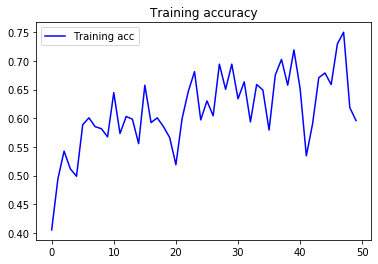

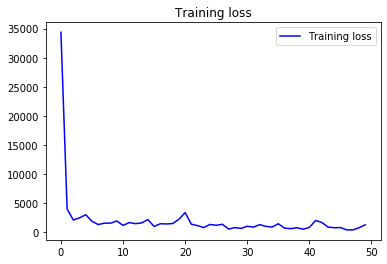

In [11]:
acc = last_train.history['acc']
loss = last_train.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()


plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()
 
plt.show()

### Save trained model to output directory

In [12]:
import pickle

output_folder = os.path.join(os.getcwd(), 'output')
os.makedirs(output_folder, exist_ok=True)

model.save(output_folder)

WARNING - From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Register as Model on Azure

In [13]:
model = Run.register_model(model_name='derm-classifier', model_path='output/derm-classifier.pkl')

TypeError: register_model() missing 1 required positional argument: 'self'